In [1]:
import tensorflow as tf
import keras
from keras.initializers import Constant
#from keras import SGD
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Load the fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist

In [36]:
# Load the training and test split of the dataset
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

In [37]:
# Normalize the pixel values of the train and test images
training_images  = training_images / 255.0
test_images = test_images / 255.0

In [5]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 99.5 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.995):

      # Stop if threshold is met
      print("\nAccuracy is greater than 0.995 so cancelling training.")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [38]:
def unsaturated(number, threshold):
    if number > threshold:
        return 1
    else:
        return 0

In [39]:
def unsaturated_tanh(number):
    if (number > -0.95) and (number <0.95):
        return 1
    else:
        return 0

In [40]:
Unsaturated=np.vectorize(unsaturated)

In [41]:
Unsaturated_tanh=np.vectorize(unsaturated_tanh)

In [42]:
# LAYER is a string 
def actProb(MODEL, LAYER):
    List=[]
    for image in test_images:
        intermediate_output = tf.keras.Model(MODEL.input, 
                                    MODEL.get_layer(LAYER).output)
        extracted = intermediate_output(image[None, ...])
        List.append(Unsaturated(extracted,0))
        
    X=np.array(List).sum(axis=0)/len(test_images)
    X=np.flip(np.sort(X.flatten()))
    return X

In [43]:
# LAYER is a string 
def actProb_tanh(MODEL, LAYER):
    List=[]
    for image in test_images:
        intermediate_output = tf.keras.Model(MODEL.input, 
                                    MODEL.get_layer(LAYER).output)
        extracted = intermediate_output(image[None, ...])
        List.append(Unsaturated_tanh(extracted))
        
    X=np.array(List).sum(axis=0)/len(test_images)
    X=np.flip(np.sort(X.flatten()))
    return X

### ReLU

In [12]:
# Build the classification model
modelR = tf.keras.models.Sequential([
    
    # Convolution Layers
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected Layers
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [13]:
modelR.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
modelR.fit(training_images, training_labels, epochs=5) # callbacks=[callbacks]

Epoch 1/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.4676 - accuracy: 0.8297
Epoch 2/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.3181 - accuracy: 0.8832
Epoch 3/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2711 - accuracy: 0.9000
Epoch 4/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2396 - accuracy: 0.9107
Epoch 5/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2141 - accuracy: 0.9197


In [15]:
# Evaluate the model on unseen data
modelR.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.2586 - accuracy: 0.9060


[0.25859859585762024, 0.906000018119812]

In [16]:
list(map(lambda x: x.name, modelR.layers))

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

In [17]:
ReLU_activation_probabilities=actProb(modelR,"conv2d_1")

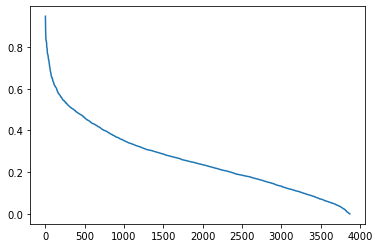

In [18]:
# numConv=32 
plt.plot(ReLU_activation_probabilities)

In [19]:
ReLU_activation_probabilities.mean(),ReLU_activation_probabilities.std()

(0.26505563016528927, 0.16135207655237677)

### LReLU

In [20]:
# Build the classification model
modelL = tf.keras.models.Sequential([
    
    # Convolution Layers
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected Layers
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [21]:
modelL.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
modelL.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])

Epoch 1/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4725 - accuracy: 0.8299
Epoch 2/5
1875/1875 [==============================] - 44s 24ms/step - loss: 0.3162 - accuracy: 0.8847
Epoch 3/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2684 - accuracy: 0.9018
Epoch 4/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2371 - accuracy: 0.9116
Epoch 5/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2100 - accuracy: 0.9208


In [23]:
modelL.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 8ms/step - loss: 0.2824 - accuracy: 0.9000


[0.28242257237434387, 0.8999999761581421]

In [24]:
list(map(lambda x: x.name, modelL.layers))

['conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'flatten_1',
 'dense_2',
 'dense_3']

In [25]:
LReLU_activation_probabilities=actProb(modelL,"conv2d_3")

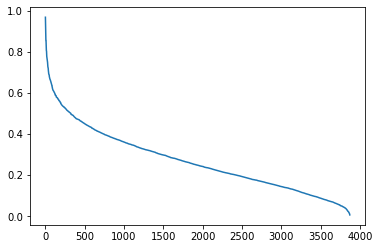

In [44]:
plt.plot(LReLU_activation_probabilities)

In [26]:
LReLU_activation_probabilities.mean(),LReLU_activation_probabilities.std()

(0.26994129648760334, 0.15285542087806653)

### htan

In [45]:
# Build the classification model
modelT = tf.keras.models.Sequential([
    
    # Convolution Layers
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.tanh, input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.tanh),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected Layers
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [46]:
modelT.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
modelT.fit(training_images, training_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4603 - accuracy: 0.8323
Epoch 2/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3140 - accuracy: 0.8841
Epoch 3/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.2680 - accuracy: 0.8995
Epoch 4/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2343 - accuracy: 0.9126
Epoch 5/5
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2123 - accuracy: 0.9200


In [48]:
modelT.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 8ms/step - loss: 0.2749 - accuracy: 0.8972


[0.27494552731513977, 0.8971999883651733]

In [49]:
list(map(lambda x: x.name, modelT.layers))

['conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7',
 'flatten_3',
 'dense_6',
 'dense_7']

In [50]:
htan_activation_probabilities=actProb_tanh(modelT,"conv2d_7")

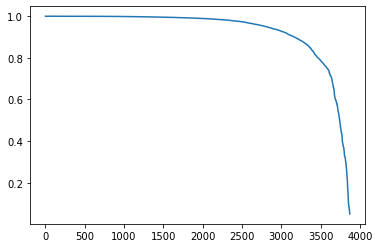

In [51]:
plt.plot(htan_activation_probabilities)

In [52]:
htan_activation_probabilities.mean(),htan_activation_probabilities.std()

(0.9314449896694215, 0.14508127784271513)

### PReLU 

In [53]:
# tf.keras.layers.PReLU(alpha_initializer=constant(value=0.25))

In [54]:
# Build the classification model
modelP = tf.keras.models.Sequential([
    
    # Convolution Layers
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.layers.PReLU(alpha_initializer=Constant(value=0.25)), input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.layers.PReLU(alpha_initializer=Constant(value=0.25))),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected Layers
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [55]:
modelP.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
modelP.fit(training_images, training_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 68s 36ms/step - loss: 0.4595 - accuracy: 0.8335
Epoch 2/5
1875/1875 [==============================] - 67s 36ms/step - loss: 0.3037 - accuracy: 0.8890
Epoch 3/5
1875/1875 [==============================] - 67s 36ms/step - loss: 0.2566 - accuracy: 0.9046
Epoch 4/5
1875/1875 [==============================] - 68s 36ms/step - loss: 0.2255 - accuracy: 0.9164
Epoch 5/5
1875/1875 [==============================] - 67s 36ms/step - loss: 0.1979 - accuracy: 0.9265


In [57]:
modelP.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 11ms/step - loss: 0.2551 - accuracy: 0.9080


[0.2550932765007019, 0.9079999923706055]

In [60]:
list(map(lambda x: x.name, modelP.layers))

['conv2d_8',
 'max_pooling2d_8',
 'conv2d_9',
 'max_pooling2d_9',
 'flatten_4',
 'dense_8',
 'dense_9']

In [61]:
PReLU_activation_probabilities=actProb(modelP,"conv2d_9")

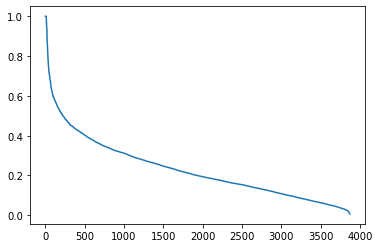

In [62]:
plt.plot(PReLU_activation_probabilities)

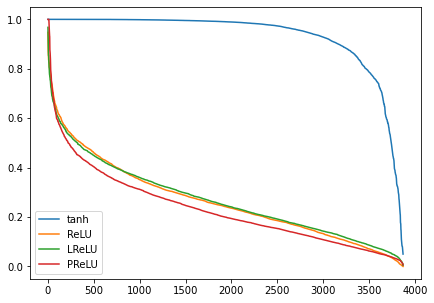

In [63]:
fig=plt.figure(figsize=(7,5))
plt.plot(htan_activation_probabilities, label='tanh')
plt.plot(ReLU_activation_probabilities, label='ReLU')
plt.plot(LReLU_activation_probabilities, label='LReLU')
plt.plot(PReLU_activation_probabilities, label='PReLU')
plt.legend()
plt.show()

In [64]:
htan_activation_probabilities.mean(),htan_activation_probabilities.std()

(0.9314449896694215, 0.14508127784271513)

In [65]:
ReLU_activation_probabilities.mean(),ReLU_activation_probabilities.std()

(0.26505563016528927, 0.16135207655237677)

In [66]:
LReLU_activation_probabilities.mean(),LReLU_activation_probabilities.std()

(0.26994129648760334, 0.15285542087806653)

In [67]:
PReLU_activation_probabilities.mean(),PReLU_activation_probabilities.std()

(0.23261616735537194, 0.15555803996751172)